In [1]:
import os
import json
import requests
import datetime
import numpy as np
import pandas as pd
import folium, folium.plugins
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SF = (37.78, -122.446)

In [3]:
#df = pd.read_csv('https://data.sfgov.org/api/views/h3eg-w3pj/rows.csv?accessType=DOWNLOAD')
#df.to_csv('sfpoo.csv', index = False)
df = pd.read_csv('sfpoo.csv')
df = df.astype(str)
df.head(2)

,CaseID,Opened,Closed,Status,Responsible Agency,Address,Category,Request Type,Request Details,Source,Supervisor District,Neighborhood,Updated,Point
0,322566,11/30/2008 10:56:00 PM,07/21/2009 04:24:00 PM,Closed,DPW Ops Queue,"1566 HYDE ST, SAN FRANCISCO, CA, 94109",Street and Sidewalk Cleaning,Sidewalk_Cleaning,Garbage,Voice In,3,Nob Hill,07/21/2009 04:24:00 PM,"(37.795328529, -122.418067787)"
1,322560,11/30/2008 10:24:00 PM,07/21/2009 04:24:00 PM,Closed,DPW Ops Queue,Intersection of TAYLOR ST and TURK ST,Street and Sidewalk Cleaning,Illegal_Dumping,Garbage,Voice In,6,Downtown/Civic Center,07/21/2009 04:24:00 PM,"(37.7832142923006, -122.410764953722)"


In [4]:
# Cleeeennnuppp.
df['Request Details'] =  df['Request Details'].fillna('')
pooset = set([x for x in set(df['Request Details'].unique()) if 'human' in x.lower()])
print(pooset)
dfpoo = df[df['Request Details'].isin(pooset)]
print(dfpoo.shape)
dfpoo.head(2)

{'Sidewalk_Cleaning - Human_waste_or_urine', 'Illegal_Dumping - Human_waste_or_urine', 'Human Waste', 'Street_Cleaning - Human_waste_or_urine', 'Human_waste_or_urine'}
(63584, 14)


,CaseID,Opened,Closed,Status,Responsible Agency,Address,Category,Request Type,Request Details,Source,Supervisor District,Neighborhood,Updated,Point
3,322556,11/30/2008 09:34:00 PM,12/09/2008 08:07:00 AM,Closed,DPW Ops Queue,Intersection of 25TH ST and LUCKY ST,Street and Sidewalk Cleaning,Sidewalk_Cleaning,Human_waste_or_urine,Voice In,9,Mission,12/09/2008 08:07:00 AM,"(37.7509362479361, -122.413364630104)"
11,322511,11/30/2008 06:50:00 PM,12/01/2008 04:24:00 PM,Closed,DPW Ops Queue,"647 MINNA ST, SAN FRANCISCO, CA, 94103",Street and Sidewalk Cleaning,Sidewalk_Cleaning,Human_waste_or_urine,Voice In,6,South of Market,12/01/2008 04:24:00 PM,"(37.777796575, -122.41137518)"


In [5]:
dfpoogeo = dfpoo[dfpoo.Point.apply(lambda x: x[1:-1].split(', ')[0].startswith('37'))]
dfpoogeo.loc[:,'lat'] = dfpoogeo.Point.apply(lambda x: float(x[1:-1].split(', ')[0]))
dfpoogeo.loc[:,'lon'] = dfpoogeo.Point.apply(lambda x: float(x[1:-1].split(', ')[1]))
dfpoogeo.loc[:,'Opened'] = dfpoogeo.Opened.apply(lambda x: datetime.datetime.strptime(x[:10], '%m/%d/%Y'))
print(dfpoogeo.shape)
dfpoogeo.head(2)

/usr/lib64/python3.4/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/lib64/python3.4/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(63277, 16)


,CaseID,Opened,Closed,Status,Responsible Agency,Address,Category,Request Type,Request Details,Source,Supervisor District,Neighborhood,Updated,Point,lat,lon
3,322556,2008-11-30,12/09/2008 08:07:00 AM,Closed,DPW Ops Queue,Intersection of 25TH ST and LUCKY ST,Street and Sidewalk Cleaning,Sidewalk_Cleaning,Human_waste_or_urine,Voice In,9,Mission,12/09/2008 08:07:00 AM,"(37.7509362479361, -122.413364630104)",37.750936,-122.413365
11,322511,2008-11-30,12/01/2008 04:24:00 PM,Closed,DPW Ops Queue,"647 MINNA ST, SAN FRANCISCO, CA, 94103",Street and Sidewalk Cleaning,Sidewalk_Cleaning,Human_waste_or_urine,Voice In,6,South of Market,12/01/2008 04:24:00 PM,"(37.777796575, -122.41137518)",37.777797,-122.411375


In [6]:
amap = folium.Map(location=SF, tiles='Stamen Toner', zoom_start=14)
amap.add_children(folium.LatLngPopup())
dat = dfpoogeo[dfpoogeo.Opened >= '2016-05-23'].as_matrix(['lat','lon'])
amap.add_children(folium.plugins.HeatMap(dat))
amap

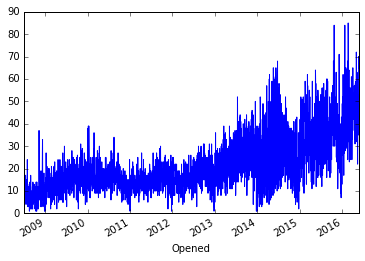

In [7]:
dfpoogeo.groupby(['Opened']).CaseID.count().plot()